## Predicting Peak Oil Production Rate

In this project, we will build a series of models to predict the peak oil production rate of an oil well. Predicting this quantity provides valuable
insights on the overall production profile of an oil well, which is essential for making informed decisions down the road.

## Outline

The workflow of our approach is as follows:
- Data Exploration and Pre-processing: Visualize the raw input data and observe patterns in correlation. Then, pre-process the data in a reasonable manner.
- Model Building: Construct baseline linear and non-linear models to predict the peak oil production rate.
- Evaluation: Use R-Squared and RMSE to evaluate the models and compare their performance. 
- Conclusions: Draw conclusions on performance capablity based on the evaluation phase.

## Data Exploration

There are numerous descriptive variables in our dataset. These include:
- relative_well_position
- batch_frac_classification
- frac_type
- well_family_relationship
- ffs_frac_type

In [187]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from typing import *

# Import libraries for machine learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Import libraries for random forest
from sklearn.ensemble import RandomForestRegressor

# Import libraries for SVR
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Import libraries for neural networks
import tensorflow as tf
from tensorflow import keras

# Import libraries for metrics
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore, randint
from itertools import combinations
from scipy.stats import f_oneway

# Ignore warnings
warnings.simplefilter("ignore")

# Path to the training data
training_path = "./training.csv"

Start by reading in the training data and dropping any irrelevant features. Also, drop any rows that do not have an OilPeakRate value.

In [188]:
raw_df = pd.read_csv(training_path)
raw_df = raw_df.drop(columns=["Unnamed: 0", "bh_x", "bh_y", "standardized_operator_name", "number_of_stages", "average_stage_length", "average_proppant_per_stage",
                              "average_frac_fluid_per_stage", 'frac_fluid_to_proppant_ratio', 'pad_id', 'frac_type', 'frac_seasoning', 'bin_lateral_length', 'ffs_frac_type'])
raw_df = raw_df.dropna(subset=["OilPeakRate"])
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19306 entries, 0 to 29436
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   surface_x                     19306 non-null  float64
 1   surface_y                     19306 non-null  float64
 2   gross_perforated_length       19148 non-null  float64
 3   total_proppant                17912 non-null  float64
 4   total_fluid                   17866 non-null  float64
 5   true_vertical_depth           19201 non-null  float64
 6   proppant_intensity            17872 non-null  float64
 7   frac_fluid_intensity          17821 non-null  float64
 8   proppant_to_frac_fluid_ratio  17501 non-null  float64
 9   relative_well_position        19306 non-null  object 
 10  batch_frac_classification     19306 non-null  object 
 11  well_family_relationship      19306 non-null  object 
 12  horizontal_midpoint_x         19249 non-null  float64
 13  horizo

In [189]:
for col in raw_df.columns:
    if pd.api.types.is_numeric_dtype(raw_df[col]):
         # For numerical columns, print the range of values
        print(f"Numerical column: {col}, Range: {raw_df[col].min()} to {raw_df[col].max()}")
    else:
        # For string columns, print unique values
        unique_values = raw_df[col].unique()
        print(f"String column: {col}, Unique values: {', '.join(map(str, unique_values))}")

Numerical column: surface_x, Range: 562787.3545 to 1728208.773
Numerical column: surface_y, Range: 496529.4327 to 1811474.875
Numerical column: gross_perforated_length, Range: 396.6535433 to 15744.09449
Numerical column: total_proppant, Range: 0.0 to 91090733.46
Numerical column: total_fluid, Range: 664.2858171 to 34424016.59
Numerical column: true_vertical_depth, Range: 1994.094488 to 13257.87402
Numerical column: proppant_intensity, Range: 0.0 to 18203.81298
Numerical column: frac_fluid_intensity, Range: 0.132961858 to 5901.9238700000005
Numerical column: proppant_to_frac_fluid_ratio, Range: 0.0 to 127.700206
String column: relative_well_position, Unique values: Standalone Well, Outer Well, Inner Well, Unknown
String column: batch_frac_classification, Unique values: Unknown, Non-Batch Frac, Batch-Sequential Frac, Batch-Concurrent Frac
String column: well_family_relationship, Unique values: Standalone Well, Infill Child Well, Sibling Well, Unknown
Numerical column: horizontal_midpoint

In [190]:
def print_num_targetstring(raw_df, col_name, target_string):

    # Count the occurrences of the target string in the column
    count_target_string = raw_df[col_name].value_counts().get(target_string, 0)

    # Print the result
    print(f"Number of occurrences of '{target_string}' in the column '{col_name}': {count_target_string}")



In [191]:
print_num_targetstring(raw_df, 'batch_frac_classification', 'Unknown')
print_num_targetstring(raw_df, 'well_family_relationship', 'Unknown')
print_num_targetstring(raw_df, 'relative_well_position', 'Unknown')

Number of occurrences of 'Unknown' in the column 'batch_frac_classification': 4844
Number of occurrences of 'Unknown' in the column 'well_family_relationship': 456
Number of occurrences of 'Unknown' in the column 'relative_well_position': 456


In [152]:
# Drop all unknowns in well_family_relationship because it is not a sizeable amount of data, and we do not want to specifically train our model in this case.
raw_df = raw_df[raw_df['well_family_relationship'] != 'Unknown']
print(raw_df)

          surface_x     surface_y  gross_perforated_length  total_proppant  \
0      1.383494e+06  7.173292e+05              3963.582677     76000.00000   
1      1.380344e+06  7.119163e+05              3179.133858    113000.00000   
2      1.379916e+06  7.178450e+05              3810.039370    286571.42860   
3      1.383567e+06  7.066402e+05              3723.425197    106878.92860   
4      1.378963e+06  7.026240e+05              3811.023622    112789.71430   
...             ...           ...                      ...             ...   
29432  9.477118e+05  1.057502e+06              4101.377953     95857.14286   
29433  9.593475e+05  1.033564e+06              4512.795276             NaN   
29434  9.669162e+05  1.057804e+06              3660.433071     87857.14286   
29435  9.462629e+05  1.034169e+06              5930.118110    383857.14290   
29436  9.467048e+05  1.035064e+06              6141.732283    406571.42860   

        total_fluid  true_vertical_depth  proppant_intensity  \

In [192]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19306 entries, 0 to 29436
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   surface_x                     19306 non-null  float64
 1   surface_y                     19306 non-null  float64
 2   gross_perforated_length       19148 non-null  float64
 3   total_proppant                17912 non-null  float64
 4   total_fluid                   17866 non-null  float64
 5   true_vertical_depth           19201 non-null  float64
 6   proppant_intensity            17872 non-null  float64
 7   frac_fluid_intensity          17821 non-null  float64
 8   proppant_to_frac_fluid_ratio  17501 non-null  float64
 9   relative_well_position        19306 non-null  object 
 10  batch_frac_classification     19306 non-null  object 
 11  well_family_relationship      19306 non-null  object 
 12  horizontal_midpoint_x         19249 non-null  float64
 13  horizo

## Preliminary Visualization

In [193]:
all_variables_df = raw_df.dropna()
all_variables_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17423 entries, 1 to 29436
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   surface_x                     17423 non-null  float64
 1   surface_y                     17423 non-null  float64
 2   gross_perforated_length       17423 non-null  float64
 3   total_proppant                17423 non-null  float64
 4   total_fluid                   17423 non-null  float64
 5   true_vertical_depth           17423 non-null  float64
 6   proppant_intensity            17423 non-null  float64
 7   frac_fluid_intensity          17423 non-null  float64
 8   proppant_to_frac_fluid_ratio  17423 non-null  float64
 9   relative_well_position        17423 non-null  object 
 10  batch_frac_classification     17423 non-null  object 
 11  well_family_relationship      17423 non-null  object 
 12  horizontal_midpoint_x         17423 non-null  float64
 13  horizo

<Axes: >

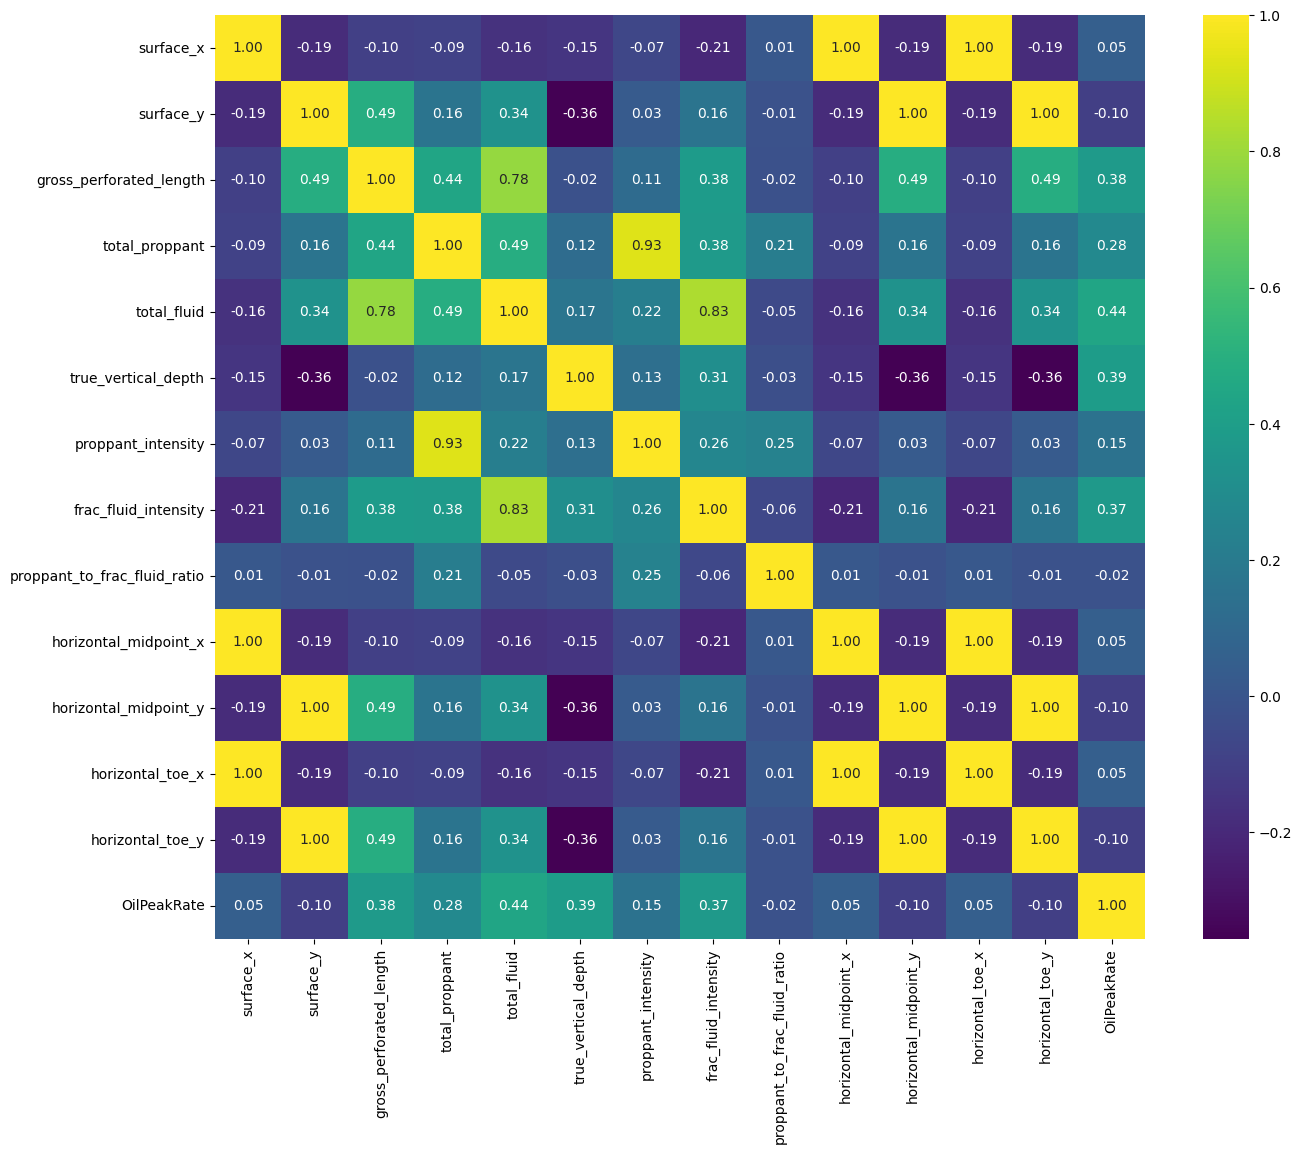

In [194]:
plt.figure(figsize=(15, 12))
# Selecting only the non-categorical variables from the DataFrame
non_categorical_data = all_variables_df.select_dtypes(include=[np.number])
sns.heatmap(non_categorical_data.corr(), annot=True, fmt=".2f", cmap='viridis')

In [195]:
# Visualize the well family relationship and relative well position variables.
result = raw_df.groupby(['relative_well_position', 'well_family_relationship'])['OilPeakRate'].mean().reset_index()
print(result)

  relative_well_position well_family_relationship  OilPeakRate
0             Inner Well        Infill Child Well   232.158172
1             Inner Well             Sibling Well   274.315485
2             Outer Well        Infill Child Well   200.458078
3             Outer Well             Sibling Well   250.264220
4        Standalone Well          Standalone Well   190.501878
5                Unknown                  Unknown   147.689081


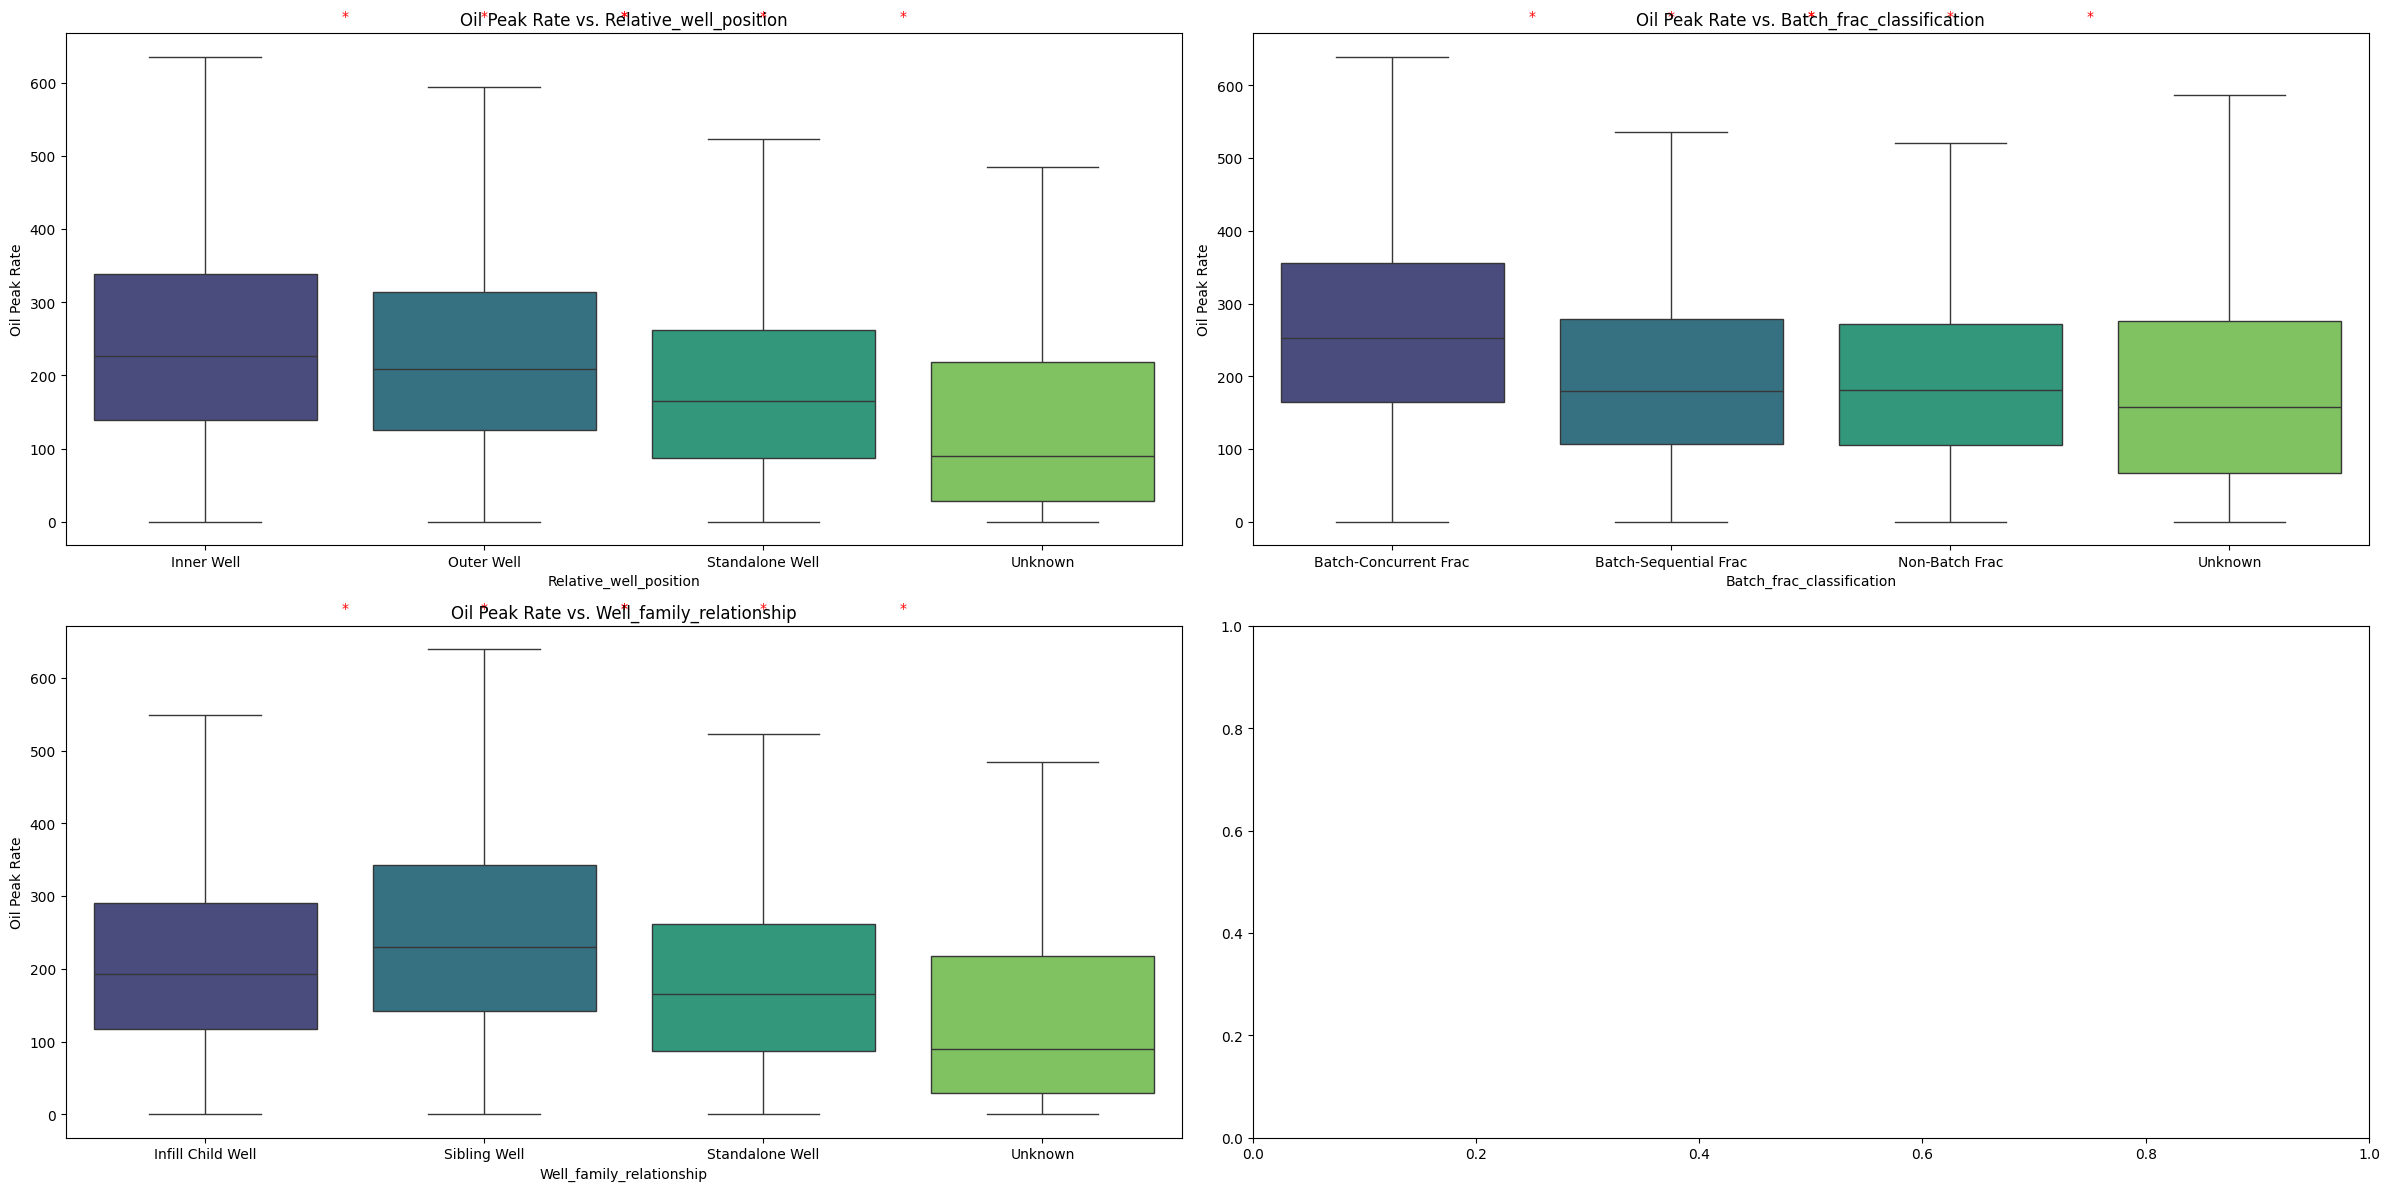

In [196]:
def add_significance_stars(ax, data, category, value_column):
    # Perform one-way ANOVA test for each pair of categories
    categories = data[category].unique()
    ylim = ax.get_ylim()  # Get y-axis limits

    for pair in combinations(categories, 2):
        cat1_data = data[data[category] == pair[0]][value_column]
        cat2_data = data[data[category] == pair[1]][value_column]
        
        # Perform ANOVA test
        _, p_value = f_oneway(cat1_data, cat2_data)
        
        # Add stars for statistical significance
        if p_value < 0.05:
            x_position = (pair[0] + pair[1]) / 2
            y_position = ylim[1] + 0.02 * (ylim[1] - ylim[0])  # Adjust the height
            ax.text(x_position, y_position, '*', ha='center', va='bottom', color='red')

def visualize_categorical_variable(raw_df: pd.DataFrame, category: str, ax):
    df = raw_df.dropna(subset=[category])

    unique_values = df[category].unique()
    position_mapping = {value: index for index, value in enumerate(sorted(unique_values))}

    # Replace the category values in the DataFrame with their corresponding numeric mappings
    df[category] = df[category].replace(position_mapping)

    # Plotting on the provided axis
    sns.boxplot(data=df, x=category, y='OilPeakRate', palette='viridis', showfliers=False, ax=ax)
    
    # Customizing the plot
    ax.set_title(f'Oil Peak Rate vs. {category.capitalize()}')
    ax.set_xlabel(category.capitalize())
    ax.set_ylabel('Oil Peak Rate')

    ax.set_xticks(range(len(position_mapping)))
    ax.set_xticklabels(list(position_mapping.keys()))

    # Add stars for statistical significance
    add_significance_stars(ax, df, category, 'OilPeakRate')

# Assuming raw_df is your DataFrame
fig, axs = plt.subplots(2, 2, figsize=(24, 12))

# Use the modified function to plot each category in one of the subplots
visualize_categorical_variable(raw_df, "relative_well_position", axs[0, 0])
visualize_categorical_variable(raw_df, "batch_frac_classification", axs[0, 1])
visualize_categorical_variable(raw_df, "well_family_relationship", axs[1, 0])

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [197]:
# raw_df = raw_df.drop(columns=["ffs_frac_type", "relative_well_position"])
unique_values = raw_df["batch_frac_classification"].unique()
position_mapping = {'Batch-Concurrent Frac': 0, 'Batch-Sequential Frac': 1, 'Non-Batch Frac': 1, 'Unknown': 1}

# Replace the category values in the DataFrame with their corresponding numeric mappings
raw_df["batch_frac_classification"] = raw_df["batch_frac_classification"].replace(position_mapping)

unique_values = raw_df["well_family_relationship"].unique()
position_mapping = {value: index for index, value in enumerate(sorted(unique_values))}

# Replace the category values in the DataFrame with their corresponding numeric mappings
raw_df["well_family_relationship"] = raw_df["well_family_relationship"].replace(position_mapping)

unique_values = raw_df["relative_well_position"].unique()
position_mapping = {value: index for index, value in enumerate(sorted(unique_values))}

# Replace the category values in the DataFrame with their corresponding numeric mappings
raw_df["relative_well_position"] = raw_df["relative_well_position"].replace(position_mapping)

In [198]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19306 entries, 0 to 29436
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   surface_x                     19306 non-null  float64
 1   surface_y                     19306 non-null  float64
 2   gross_perforated_length       19148 non-null  float64
 3   total_proppant                17912 non-null  float64
 4   total_fluid                   17866 non-null  float64
 5   true_vertical_depth           19201 non-null  float64
 6   proppant_intensity            17872 non-null  float64
 7   frac_fluid_intensity          17821 non-null  float64
 8   proppant_to_frac_fluid_ratio  17501 non-null  float64
 9   relative_well_position        19306 non-null  int64  
 10  batch_frac_classification     19306 non-null  int64  
 11  well_family_relationship      19306 non-null  int64  
 12  horizontal_midpoint_x         19249 non-null  float64
 13  horizo

In [199]:
def print_corr_cols(input_df, col_1, col_2):
    """
    Prints the correlation coefficient between col_1 and col_2 in input_df.
    """
    proppant_cleaned = input_df[[col_1, col_2]].dropna()
    correlation = proppant_cleaned[col_1].corr(proppant_cleaned[col_2])
    print(f"Correlation between '{col_1}' and '{col_2}': {correlation}")
    

# Linear Regression: Test
At this stage, we will try a simple linear model to see how well it performs given our choice of filtering out certain variables.

We will drop the variables related to the number of stages ('number_of_stages', 'average_stage_length', 'average_proppant_per_stage', 'average_frac_fluid_per_stage') as we do not have enough datapoints for these variables, and we believe that the number of stages/length of each stage is captured by the 'gross_perforated_length' variable, and the proppant and frac fluid data is captured by the 'total_proppant' and 'total_fluid' variables.

In [107]:
# print_corr_cols(raw_df, 'proppant_intensity', 'average_proppant_per_stage')
# print_corr_cols(raw_df, 'frac_fluid_intensity', 'average_frac_fluid_per_stage')
# print_corr_cols(raw_df, 'number_of_stages', 'true_vertical_depth')
# print_corr_cols(raw_df, 'number_of_stages', 'gross_perforated_length')

KeyError: "['average_proppant_per_stage'] not in index"

In [24]:
# stage_columns_to_drop = ['number_of_stages', 'average_stage_length', 'average_proppant_per_stage', 'average_frac_fluid_per_stage']

# raw_df = raw_df.drop(columns=stage_columns_to_drop)

In [200]:
raw_df.head()

,surface_x,surface_y,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,proppant_to_frac_fluid_ratio,relative_well_position,batch_frac_classification,well_family_relationship,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate
0,1383493.751,717329.2368,3963.582677,76000.0000,NaN,8712.598425,19.174572,NaN,NaN,2,1,2,1383030.678,714796.3610,1382668.912,712798.4321,46.623023
1,1380344.035,711916.2732,3179.133858,113000.0000,5.610964e+05,8627.952756,35.544272,176.493480,0.201391,1,1,0,1379965.126,709541.7145,1379630.025,707907.6708,59.750009
2,1379915.895,717845.0063,3810.039370,286571.4286,1.621424e+06,8801.181102,75.214821,425.566078,0.176741,2,1,2,1379357.250,715381.2327,1378960.372,713530.4490,10.785716
3,1383567.443,706640.2010,3723.425197,106878.9286,4.377134e+05,8635.826772,28.704465,117.556659,0.244176,2,1,2,1383099.610,704058.8508,1382727.299,702098.4882,123.797638
4,1378962.585,702623.9787,3811.023622,112789.7143,6.229802e+05,8664.370079,29.595648,163.467933,0.181049,1,1,0,1379546.414,705150.7519,1379987.487,707123.7258,102.309540


In [201]:
raw_df.shape

(19306, 17)

In [202]:
count_nan_rows = raw_df[raw_df.isna().any(axis=1)].shape[0]
print('Number of rows with at least one NaN value:', count_nan_rows)

Number of rows with at least one NaN value: 1883


In [203]:
# As we have no way of filling in unknown values, we decide to drop all rows with at least one NaN value.
raw_df.dropna(inplace=True)

In [204]:
raw_df.shape

(17423, 17)

In [205]:
raw_df.head()

,surface_x,surface_y,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,proppant_to_frac_fluid_ratio,relative_well_position,batch_frac_classification,well_family_relationship,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate
1,1380344.035,711916.2732,3179.133858,113000.0000,5.610964e+05,8627.952756,35.544272,176.493480,0.201391,1,1,0,1379965.126,709541.7145,1379630.025,707907.6708,59.750009
2,1379915.895,717845.0063,3810.039370,286571.4286,1.621424e+06,8801.181102,75.214821,425.566078,0.176741,2,1,2,1379357.250,715381.2327,1378960.372,713530.4490,10.785716
3,1383567.443,706640.2010,3723.425197,106878.9286,4.377134e+05,8635.826772,28.704465,117.556659,0.244176,2,1,2,1383099.610,704058.8508,1382727.299,702098.4882,123.797638
4,1378962.585,702623.9787,3811.023622,112789.7143,6.229802e+05,8664.370079,29.595648,163.467933,0.181049,1,1,0,1379546.414,705150.7519,1379987.487,707123.7258,102.309540
5,1381250.408,702293.2344,3536.417323,93000.0000,5.638857e+05,8668.307087,26.297801,159.451108,0.164927,0,1,0,1382166.864,704872.4045,1382717.737,706720.3298,98.630968


In [206]:
raw_df.to_csv('cleaned_training_nostages_filtered_relpos_moredata.csv', index=False)

In [207]:
infinity_mask = np.isinf(raw_df)

rows_with_infinity = raw_df[infinity_mask.any(axis=1)]
print('Rows with at least one infinity value:', rows_with_infinity)

Rows with at least one infinity value: Empty DataFrame
Columns: [surface_x, surface_y, gross_perforated_length, total_proppant, total_fluid, true_vertical_depth, proppant_intensity, frac_fluid_intensity, proppant_to_frac_fluid_ratio, relative_well_position, batch_frac_classification, well_family_relationship, horizontal_midpoint_x, horizontal_midpoint_y, horizontal_toe_x, horizontal_toe_y, OilPeakRate]
Index: []


In [208]:
# We drop all rows with any infinity values, as we are unsure the exact ratio of frac fluid to proppants in this case.
raw_df.replace([np.inf, -np.inf], np.nan, inplace=True)

raw_df = raw_df.dropna()

We now attempt to train a random forest regressor on the input dataset.

In [209]:
def remove_outliers(X_train, y_train):
    """
    Removes the outliers from the input dataset using z-score calculations.
    """
    # Assuming X_train and y_train are your feature and target DataFrames
    combined_df = pd.concat([X_train, y_train], axis=1)

    # Calculate Z-Score for each data point in the combined dataset
    z_scores_combined = zscore(combined_df)

    # Define a threshold for Z-Score (e.g., 3)
    z_threshold = 3

    # Identify rows with outliers based on Z-Score
    outlier_indices_combined = (z_scores_combined > z_threshold).any(axis=1)

    # Remove outliers from the combined DataFrame
    combined_df_cleaned = combined_df[~outlier_indices_combined]

    # Split back into X_train and y_train
    X_train_cleaned = combined_df_cleaned.iloc[:, :-1]
    y_train_cleaned = combined_df_cleaned.iloc[:, -1]

    return (X_train_cleaned, y_train_cleaned)

In [210]:
X = raw_df.drop('OilPeakRate', axis=1)
y = raw_df['OilPeakRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

In [213]:
param_dist = {
    'n_estimators': randint(10, 200),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}
random_search = RandomizedSearchCV(
    rf_regressor, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14bf54090>,
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14bf56ad0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1478ada50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14bbda590>},
                   random_state=42, scoring='neg_mean_squared_error')

In [178]:
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'bootstrap': False, 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 139}


In [179]:
best_rf_regressor = random_search.best_estimator_
y_pred = best_rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error, tuned: {mse}')

Mean squared error, tuned: 8780.493005838913


In [211]:
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

Mean squared error: 8736.704164657214


In [212]:
r2 = r2_score(y_test, y_pred)
print(f'r^2 score: {r2}')

r^2 score: 0.6076776370164898


In [119]:
# Scale data for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [120]:
# Create an SVR model
svr_model = SVR(kernel='linear', C=1.0)

# Train the model
svr_model.fit(X_train_scaled, y_train)

SVR(kernel='linear')

In [121]:
y_pred_svr = svr_model.predict(X_test_scaled)

In [122]:
mse = mean_squared_error(y_test, y_pred_svr)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 38070.24024562072


In [123]:
# Attempt to train a neural network for the training data.
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [124]:
print(model)

In [125]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
430/430 [==============================] - 2s 2ms/step - loss: 6373047808.0000 - val_loss: 27689641984.0000
Epoch 2/50
430/430 [==============================] - 1s 2ms/step - loss: 32929388.0000 - val_loss: 25754658816.0000
Epoch 3/50
430/430 [==============================] - 1s 2ms/step - loss: 20076104.0000 - val_loss: 25892640768.0000
Epoch 4/50
430/430 [==============================] - 1s 2ms/step - loss: 14208879.0000 - val_loss: 34835968000.0000
Epoch 5/50
430/430 [==============================] - 1s 2ms/step - loss: 9055591.0000 - val_loss: 39543996416.0000
Epoch 6/50
430/430 [==============================] - 1s 2ms/step - loss: 7415080.0000 - val_loss: 40540610560.0000
Epoch 7/50
430/430 [==============================] - 1s 2ms/step - loss: 6283495.5000 - val_loss: 40314941440.0000
Epoch 8/50
430/430 [==============================] - 1s 2ms/step - loss: 4797220.0000 - val_loss: 36856508416.0000
Epoch 9/50
430/430 [==============================] - 1s 2ms/step 

In [126]:
nn_mse = model.evaluate(X_test, y_test)

108/108 [==============================] - 0s 1ms/step - loss: 23136444416.0000


In [127]:
print(f'MSE for NN: {mse}')

MSE for NN: 38070.24024562072
